In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root, fixed_point
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_TimeCourse_Jun9_23.xlsx"
df_br1 = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2 = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1.head()

,BatchTime,Phase,GrowthRate
0,0.000000,0.05,0.022972
1,0.016667,0.05,0.043676
2,0.033333,0.05,0.043676
3,0.050000,0.05,0.061904
4,0.066667,0.05,0.061904


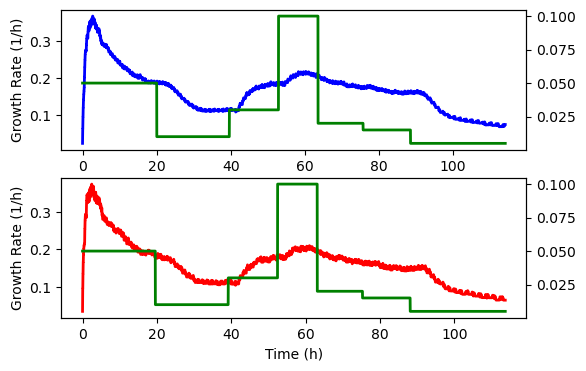

In [3]:
# Visualize Training Data

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1["BatchTime"], df_br1["GrowthRate"], linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1["BatchTime"], df_br1["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2["BatchTime"], df_br2["GrowthRate"], linewidth=2, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2["BatchTime"], df_br2["Phase"], linewidth=2, color="green", label="Bioreactor 2")

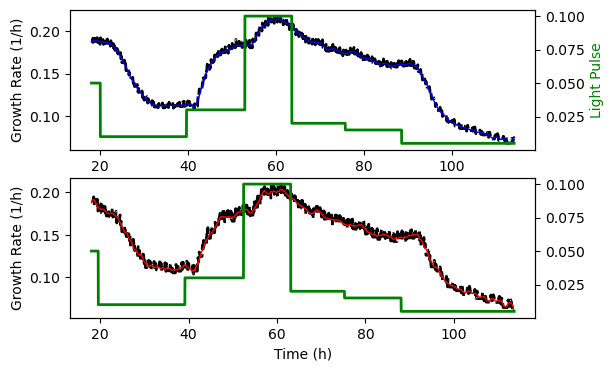

In [4]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc = df_br1[df_br1["BatchTime"] > time_cutoff].copy()
df_br2_trunc = df_br2[df_br2["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc["GrowthRateSmooth"] = savgol_filter(df_br1_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc["GrowthRateSmooth"] = savgol_filter(df_br2_trunc["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc["BatchTime"], df_br1_trunc["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc["BatchTime"], df_br1_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 1")
ax2.set_ylabel("Light Pulse", color="green")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc["BatchTime"], df_br2_trunc["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc["BatchTime"], df_br2_trunc["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.005, 0.01, 0.015, 0.02, 0.03, 0.05, 0.1]
[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


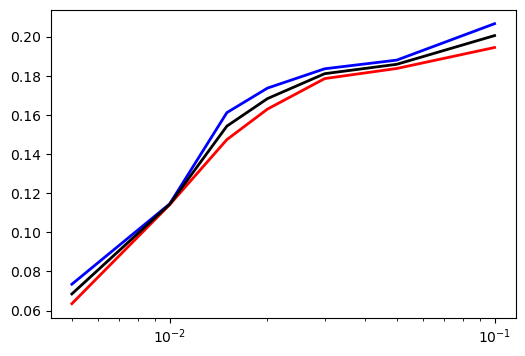

In [5]:
# Split dataframe by Phase

df_br1_trunc_grouped = df_br1_trunc.groupby("Phase")
df_br2_trunc_grouped = df_br2_trunc.groupby("Phase")

keys = list(df_br1_trunc_grouped.groups.keys())
print(keys)

mu_mean_br1 = []
mu_std_br1 = []
mu_mean_br2 = []
mu_std_br2 = []
mu_mean_overall = []
mu_std_overall = []

rangeme = 20

for key in keys:
    df = df_br1_trunc_grouped.get_group(key)
    mu_mean_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    df = df_br2_trunc_grouped.get_group(key)
    mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    mu_mean_overall.append((mu_mean_br1[-1] + mu_mean_br2[-1])/2)
    mu_std_overall.append(np.sqrt(mu_std_br1[-1]**2 + mu_std_br2[-1]**2))
    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_br1, linewidth=2, color="blue", label="Bioreactor 1")
ax.semilogx(keys, mu_mean_br2, linewidth=2, color="red", label="Bioreactor 2")
ax.semilogx(keys, mu_mean_overall, linewidth=2, color="black", label="Overall")

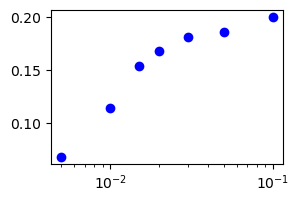

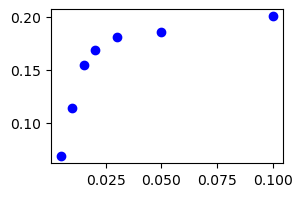

In [6]:
fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.semilogx(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

fig = plt.figure(figsize=(3, 2))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_overall, 'o', linewidth=2, color="blue", label="Bioreactor 1")

In [7]:
# Load Training Data

filename = "/home/smalani/Cybernetic_BioModel/optogenetic_model_fits/June152023Onwards/trainingData/SGy139_ActDeAct_Mar1_23.xlsx"
df_br1_actdeact = pd.read_excel(filename, sheet_name="Bioreactor1")
df_br2_actdeact = pd.read_excel(filename, sheet_name="Bioreactor2")

df_br1_actdeact.head()

,BatchTime,Phase,GrowthRate
0,0.000000,Batch_10%_1,0.021140
1,0.016667,Batch_10%_1,0.040492
2,0.033333,Batch_10%_1,0.040492
3,0.050000,Batch_10%_1,0.057788
4,0.066667,Batch_10%_1,0.057788


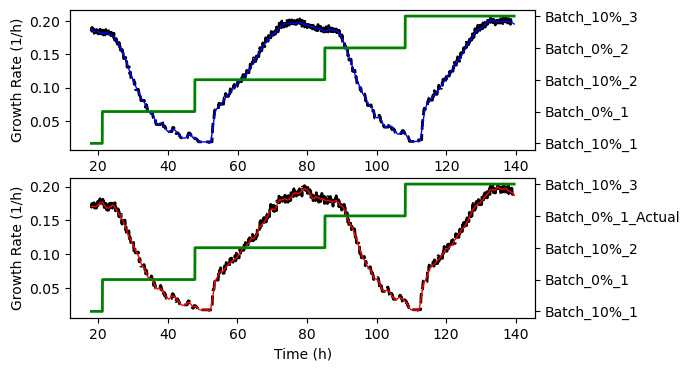

In [8]:
# Truncate and Smooth Data
from scipy.signal import savgol_filter

# Truncate data to remove initial lag phase
time_cutoff = 18
df_br1_trunc_actdeact = df_br1_actdeact[df_br1_actdeact["BatchTime"] > time_cutoff].copy()
df_br2_trunc_actdeact = df_br2_actdeact[df_br2_actdeact["BatchTime"] > time_cutoff].copy()

# Smooth data using Savitzky-Golay filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html
# Parameters
window_size = 151
poly_order = 3
deriv = 0
df_br1_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br1_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)
df_br2_trunc_actdeact["GrowthRateSmooth"] = savgol_filter(df_br2_trunc_actdeact["GrowthRate"], window_size, poly_order, deriv=deriv)

# Visualize truncated and smoothed data
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(211)
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 1 (Raw)")
ax.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="blue", label="Bioreactor 1")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br1_trunc_actdeact["BatchTime"], df_br1_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 1")

ax = fig.add_subplot(212)
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRate"], '--', linewidth=2, color="black", label="Bioreactor 2 (Raw)")
ax.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["GrowthRateSmooth"], linewidth=1, color="red", label="Bioreactor 2")
ax.set_xlabel("Time (h)")
ax.set_ylabel("Growth Rate (1/h)")
ax2 = ax.twinx()
ax2.plot(df_br2_trunc_actdeact["BatchTime"], df_br2_trunc_actdeact["Phase"], linewidth=2, color="green", label="Bioreactor 2")

[0.0734547580486065, 0.11449916164970078, 0.16115651184315924, 0.17368609162895002, 0.1835650140137684, 0.18798828591981112, 0.2066117976456574]
[0.0010881118139570098, 0.00017922013821686667, 0.0001351855672608787, 0.00023040634511450214, 0.0003416015420552834, 9.79051449885469e-05, 0.0003940932568776185]
[0.06350886004033417, 0.11409157907206488, 0.14736955059094883, 0.1629574775336532, 0.1785494072864605, 0.18371385974925505, 0.194438254015791]
[0.0020202843944336297, 0.0005138569688471562, 0.00021633159036764683, 0.0003193719741695719, 0.00022387115608396834, 0.0006227661336243767, 0.0002279725263584661]


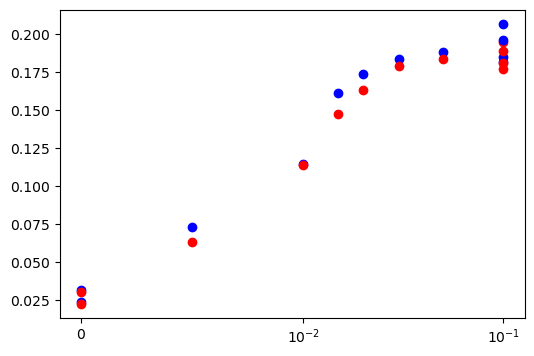

In [9]:
# Split dataframe by Phase

df_br1_trunc_actdeact_grouped = df_br1_trunc_actdeact.groupby("Phase")
df_br2_trunc_actdeact_grouped = df_br2_trunc_actdeact.groupby("Phase")

keys_br1_actdeact = list(df_br1_trunc_actdeact_grouped.groups.keys())
keys_br2_actdeact = list(df_br2_trunc_actdeact_grouped.groups.keys())

keys_add_br1 = []
keys_add_br2 = []


mu_mean_br1_actdeact = []
mu_std_br1_actdeact = []
mu_mean_br2_actdeact = []
mu_std_br2_actdeact = []

rangeme = 20

for key in keys_br1_actdeact:
    df = df_br1_trunc_actdeact_grouped.get_group(key)
    mu_mean_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br1_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br1.append(0)
    elif '_10%' in key:
        keys_add_br1.append(0.1)

for key in keys_br2_actdeact:
    df = df_br2_trunc_actdeact_grouped.get_group(key)
    mu_mean_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    mu_std_br2_actdeact.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())
    # df = df_br2_trunc_actdeact_grouped.get_group(key)
    # mu_mean_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].mean())
    # mu_std_br2.append(df["GrowthRateSmooth"].iloc[-rangeme:].std())

    if '_0%' in key:
        keys_add_br2.append(0)
    elif '_10%' in key:
        keys_add_br2.append(0.1)

    

print(mu_mean_br1)
print(mu_std_br1)
print(mu_mean_br2)
print(mu_std_br2)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys, mu_mean_br1, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys, mu_mean_br2, 'o', linewidth=2, color="red", label="Bioreactor 2")
ax.plot(keys_add_br1, mu_mean_br1_actdeact, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys_add_br2, mu_mean_br2_actdeact, 'o', linewidth=2, color="red", label="Bioreactor 2")

ax.set_xscale('symlog', linthresh=0.01)

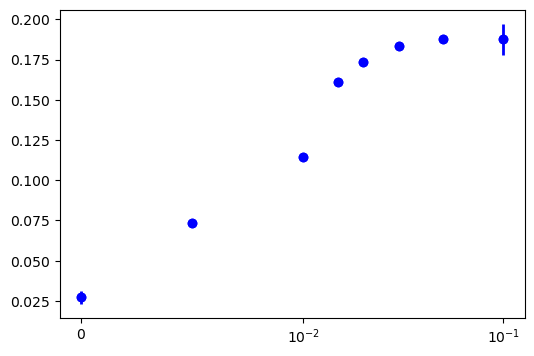

In [10]:
keys_plot = keys + keys_add_br1 + keys_add_br2
mu_plot = mu_mean_br1 + mu_mean_br1_actdeact + mu_mean_br2_actdeact
mu_plot = np.array(mu_plot)
keys_plot = np.array(keys_plot)

mu_plot = mu_plot[np.argsort(keys_plot)]
keys_plot = keys_plot[np.argsort(keys_plot)]

keys_unique = np.unique(keys_plot)
mu_unique = []
mu_std_unique = []

for key in keys_unique:
    mu_unique.append(mu_plot[keys_plot == key].mean())
    mu_std_unique.append(mu_plot[keys_plot == key].std())


fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys_unique, mu_unique, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.errorbar(keys_unique, mu_unique, yerr=mu_std_unique, fmt='o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)


In [30]:
from scipy.optimize import curve_fit, root

# Steady State Equations

def opto_ode(t, y, p, I):
    T, R = y
    kon, koff, kbasal, kmax, n, Kd, kdegR = p

    T = max(0, T)

    dTdt = I * kon  * (1-T) - koff * T
    dRdt = kbasal + kmax * (T**n / (Kd**n + T**n)) - kdegR * R

    out = np.array([dTdt, dRdt])
    return out

def opto_ode_ss(pulse, period, p, guess=None):
    Imax = 1
    if guess is None:
        guess = np.array([pulse, pulse])
    def f_solve(xinit):
        if pulse > 0:
            sol = solve_ivp(opto_ode, [0, period*pulse], xinit, args=(p, Imax,), atol=1e-6, rtol=1e-6, method="BDF")
            sol = solve_ivp(opto_ode, [period*pulse, period], sol.y[:,-1], args=(p,0), atol=1e-6, rtol=1e-6, method="BDF")
        else:
            sol = solve_ivp(opto_ode, [0, period], xinit, args=(p, 0,), atol=1e-6, rtol=1e-6, method="BDF")

        out = sol.y[:,-1] - xinit[:]
        return out

    rootsol = root(f_solve, guess, options={'xtol': 1e-8, 'maxfev': 1000})

    if not rootsol.success:
        # print("Root finding failed at pulse = ", pulse)
        return 0, 0
    
    if pulse > 0:
        sol_first = solve_ivp(opto_ode, [0, period*pulse], rootsol.x, args=(p, Imax,), atol=1e-8, rtol=1e-8, method="BDF", t_eval=np.linspace(0, period*pulse, 1000))
        sol_second = solve_ivp(opto_ode, [period*pulse, period], sol_first.y[:,-1], args=(p,0), atol=1e-8, rtol=1e-8, method="BDF", t_eval=np.linspace(period*pulse, period, 1000))

        # Average outputs by integrating over the period
        Tss = (np.trapz(sol_first.y[0,:], sol_first.t) + np.trapz(sol_second.y[0,:], sol_second.t)) / period
        Rss = (np.trapz(sol_first.y[1,:], sol_first.t) + np.trapz(sol_second.y[1,:], sol_second.t)) / period
    
    else:
        sol = solve_ivp(opto_ode, [0, period], rootsol.x, args=(p, 0,), atol=1e-8, rtol=1e-8, method="BDF", t_eval=np.linspace(0, period, 1000))
        Tss = np.trapz(sol.y[0,:], sol.t) / period
        Rss = np.trapz(sol.y[1,:], sol.t) / period

    return Tss, Rss

def myODEs(t, x, p_opto, p_growth, p_mu, pulse):
    if callable(pulse):
        pulse = pulse(t)
    # Unpack Parameters
    kon, koff, kbasal, kmax, n, Kd, kdegR = p_opto
    kAmp, nR, KR, kdeg_Amp, kE, nAmp, KAmp, kdeg_E = p_growth
    mu_max, nE, KE = p_mu

    global pulse_old, R_ss
    if pulse != pulse_old:
        period = 100
        p = kon, koff, kbasal, kmax, n, Kd, kdegR
        _, R_ss = opto_ode_ss(pulse, period, p)
        pulse_old = pulse

    # Unpack Variables
    R, Amp, E = x
    R = max(0, R)
    Amp = max(0, Amp)
    E = max(0, E)

    mu = mu_max * E**nE / (KE**nE + E**nE) 

    # Equations
    dRdt = (R_ss - R) * kdegR
    dAmpdt = kAmp * R**nR / (KR**nR + R**nR) - (kdeg_Amp + mu) * Amp
    dEdt = kE * Amp**nAmp / (KAmp**nAmp + Amp**nAmp) - (kdeg_E + mu) * E

    return np.array([dRdt, dAmpdt, dEdt])

In [31]:
# Interpolate more values for curve fit

keys_unique_interp = np.array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.03 , 0.05 , 0.08, 0.1  ])
mu_unique_interp = np.interp(keys_unique_interp, keys_unique, mu_unique)

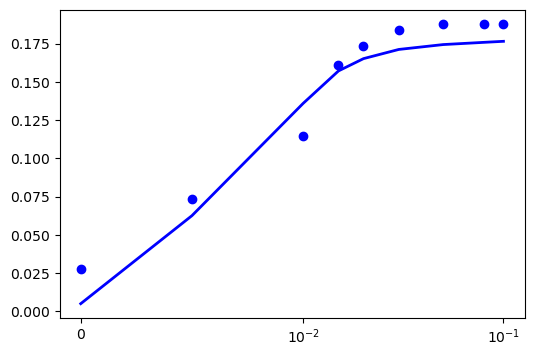

In [32]:
# Initial Guess
kon = 8.36584314e-01
koff = 3.09772171e-03
kbasal = 6.12172752e+03
kmax = 1.05442021e+05
Kd = 1.00497835e+00
n = 4.74552130e+00
kdegR = kmax

p_opto = kon, koff, kbasal, kmax, n, Kd, kdegR

kAmp = 3e-01
nR = 2
KR = 0.3
kdeg_Amp = kAmp
kE = 3.47476795e-01
KAmp = 3.62010035e-01
nAmp = 1.37571026e+00
kdeg_E = kE

p_growth = kAmp, nR, KR, kdeg_Amp, kE, nAmp, KAmp, kdeg_E

mu_max = 0.3
nE = 2
KE = 0.3
p_mu = mu_max, nE, KE


def mu_steady_rootfun(x, p_opto, p_growth, p_mu, I):
    return myODEs(0, x, p_opto, p_growth, p_mu, I)
# Plot initial guess
I_arr = keys_unique#_interp

def mu_steady_fun(pars, pulse_arr):
    p_opto = pars[:7]
    p_growth = pars[7:15]
    p_mu = pars[15:]
    mu_max, nE, KE = p_mu

    R_arr = []
    Amp_arr = []
    E_arr = []
    mu_arr = []
    for I in pulse_arr:
        sol = root(mu_steady_rootfun, [I, I, I], args=(p_opto, p_growth, p_mu, I))
        R, Amp, E = sol.x
        mu = mu_max * E**nE / (KE**nE + E**nE)
        R_arr.append(R)
        Amp_arr.append(Amp)
        E_arr.append(E)
        mu_arr.append(mu)
    return np.array(R_arr), np.array(Amp_arr), np.array(E_arr), np.array(mu_arr)

def mu_steady_minfun(pars, pulse_arr, mu_unique):
    mu_arr = mu_steady_fun(pars, pulse_arr)[-1]
    error = np.sum((mu_arr - mu_unique)**2)
    return error

Itest = 0.1
global pulse_old, R_ss
pulse_old = 0.2

mu_pred = mu_steady_fun(np.concatenate((p_opto, p_growth, p_mu)), keys_unique_interp)[-1]
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.plot(keys_unique_interp, mu_pred, '-', linewidth=2, color="blue", label="Bioreactor 1")
ax.plot(keys_unique_interp, mu_unique_interp, 'o', linewidth=2, color="blue", label="Bioreactor 1")
ax.set_xscale('symlog', linthresh=0.01)

In [33]:
s = df_br1_trunc["Phase"]
# time_array_fit = [df_br1_trunc["BatchTime"].iloc[0]]
time_array_fit = []
time_array_fit = np.append(time_array_fit, df_br1_trunc["BatchTime"][s[s.diff() != 0].index.tolist()])
time_array_fit = np.append(time_array_fit, df_br1_trunc["BatchTime"].iloc[-1])

# pulse_array_fit = [df_br1_trunc["Phase"].iloc[0]]
pulse_array_fit = []
pulse_array_fit = np.append(pulse_array_fit, df_br1_trunc["Phase"][s[s.diff() != 0].index.tolist()])
# pulse_array_fit = np.append(pulse_array_fit, df_br1_trunc["Phase"].iloc[-1])

print(time_array_fit)
print(pulse_array_fit)

#######################################################################################################################

phase_df = df_br1_trunc_actdeact["Phase"].str.extract('_(.+)%_')[0].astype(float)/100
s = phase_df
# time_array_fit = [df_br1_trunc["BatchTime"].iloc[0]]
time_array_fit_actdeact = []
time_array_fit_actdeact = np.append(time_array_fit_actdeact, df_br1_trunc_actdeact["BatchTime"][s[s.diff() != 0].index.tolist()])
time_array_fit_actdeact = np.append(time_array_fit_actdeact, df_br1_trunc_actdeact["BatchTime"].iloc[-1])

# pulse_array_fit = [df_br1_trunc["Phase"].iloc[0]]
pulse_array_fit_actdeact = []
pulse_array_fit_actdeact = np.append(pulse_array_fit_actdeact, phase_df[s[s.diff() != 0].index.tolist()])
# pulse_array_fit = np.append(pulse_array_fit, df_br1_trunc["Phase"].iloc[-1])

print(time_array_fit_actdeact)
print(pulse_array_fit_actdeact)

[ 18.01666667  20.03333333  39.63333333  52.9         63.56666667
  75.73333333  88.53333333 114.11666667]
[0.05  0.01  0.03  0.1   0.02  0.015 0.005]
[ 18.01666667  21.15        47.73333333  85.08333333 108.18333333
 139.48333333]
[0.1 0.  0.1 0.  0.1]


In [34]:
def generate_predictions(p_opto, p_growth, p_mu):
    time_array_pred = []
    mu_array_pred = []

    R0, Amp0, E0, _ = mu_steady_fun(np.concatenate((p_opto, p_growth, p_mu)), [pulse_array_fit[0]])
    x0 = np.array([R0, Amp0, E0]).flatten()
    
    for i in range(len(time_array_fit)-1):
        pulse = pulse_array_fit[i]

        tspan = [time_array_fit[i], time_array_fit[i+1]]
        t_eval = np.linspace(tspan[0], tspan[1], 1000)
        # pfixed = res.x
        
        sol = solve_ivp(myODEs, tspan, x0, method="BDF", t_eval=t_eval, args=(p_opto, p_growth, p_mu, pulse), rtol=1e-6, atol=1e-8)
        x0 = sol.y[:,-1]

        Enz = sol.y[2,:]

        mu_max, nE, KE = p_mu
        mu = mu_max * Enz**nE / (KE**nE + Enz**nE)

        time_array_pred = np.append(time_array_pred, sol.t)
        mu_array_pred = np.append(mu_array_pred, mu)

    time_array_pred = np.array(time_array_pred)
    mu_array_pred = np.array(mu_array_pred)

    time_array_pred_actdeact = []
    mu_array_pred_actdeact = []

    R0, Amp0, E0, _ = mu_steady_fun(np.concatenate((p_opto, p_growth, p_mu)), [pulse_array_fit_actdeact[0]])
    x0 = np.array([R0, Amp0, E0]).flatten()
    
    for i in range(len(time_array_fit_actdeact)-1):
        pulse = pulse_array_fit_actdeact[i]

        tspan = [time_array_fit_actdeact[i], time_array_fit_actdeact[i+1]]
        t_eval = np.linspace(tspan[0], tspan[1], 1000)
        
        sol = solve_ivp(myODEs, tspan, x0, method="BDF", t_eval=t_eval, args=(p_opto, p_growth, p_mu, pulse), rtol=1e-6, atol=1e-8)
        x0 = sol.y[:,-1]

        Enz = sol.y[2,:]
        mu_max, nE, KE = p_mu
        mu = mu_max * Enz**nE / (KE**nE + Enz**nE)

        time_array_pred_actdeact = np.append(time_array_pred_actdeact, sol.t)
        mu_array_pred_actdeact = np.append(mu_array_pred_actdeact, mu)

    time_array_pred_actdeact = np.array(time_array_pred_actdeact)
    mu_array_pred_actdeact = np.array(mu_array_pred_actdeact)

    return time_array_pred, mu_array_pred, time_array_pred_actdeact, mu_array_pred_actdeact

In [37]:
def calculate_errors(p, info):
    p_opto = p[:7]
    p_growth = p[7:15]
    p_mu = p[15:]

    mu_ss_pred = mu_steady_fun(p, keys_unique_interp)[-1]
    mu_error = np.average((mu_ss_pred - mu_unique_interp)**2)

    time_array_pred, mu_array_pred, time_array_pred_actdeact, mu_array_pred_actdeact = generate_predictions(p_opto, p_growth, p_mu)

    dynamic_error = np.average((np.interp(df_br1_trunc["BatchTime"], time_array_pred, mu_array_pred) - df_br1_trunc["GrowthRateSmooth"])**2)
    dynamic_error_actdeact = np.average((np.interp(df_br1_trunc_actdeact["BatchTime"], time_array_pred_actdeact, mu_array_pred_actdeact) - df_br1_trunc_actdeact["GrowthRateSmooth"])**2)

    # error_sum = 10 ** (10*np.log10(mu_error) + np.log10(dynamic_error) + np.log10(dynamic_error_actdeact))
    error_sum = mu_error * 10 + dynamic_error + dynamic_error_actdeact

    if error_sum < info['error_best']:
        info['error_best'] = error_sum
        info['pars_best'] = p

    if info['Nfeval']%1 == 0:
        print('Iteration: ', info['Nfeval'], ' Error: ', error_sum, ' Best Error: ', info['error_best'])
    info['Nfeval'] += 1
    return error_sum

In [38]:
from scipy.optimize import minimize, basinhopping, differential_evolution

# Initial Guess
if True:
    kon = 8.36584314e-01
    koff = 3.09772171e-03
    kbasal = 6.12172752e+03
    kmax = 1.05442021e+05
    Kd = 1.00497835e+00
    n = 4.74552130e+00
    kdegR = kmax

    p_opto = kon, koff, kbasal, kmax, n, Kd, kdegR

    kAmp = 3e-01
    nR = 2
    KR = 0.3
    kdeg_Amp = kAmp
    kE = 3.47476795e-01
    KAmp = 3.62010035e-01
    nAmp = 1.37571026e+00
    kdeg_E = kE

    p_growth = kAmp, nR, KR, kdeg_Amp, kE, nAmp, KAmp, kdeg_E

    mu_max = 0.3
    nE = 2
    KE = 0.3
    p_mu = mu_max, nE, KE

p0 = np.concatenate((p_opto, p_growth, p_mu))
bounds = [(0, 100), (0, 10), (0, 1e5), (0, 1e8), (0, 10), (1e-5, 100), (0, 1e8), # p_opto =  = kon, koff, kbasal, kmax, n, Kd, kdegR
          (0, 1e2), (0, 100), (1e-5, 10), (0, 1e2), (0, 1e2), (0, 10), (1e-5, 100), (0, 1e2), # p_growth = kAmp, nR, KR, kdeg_Amp, kE, nAmp, KAmp, kdeg_E
          (0, 10), (0, 100), (1e-5, 10) # p_mu = mu_max, nE, KE
          ] 

info = {'Nfeval': 0, 'error_best': np.inf, 'pars_best': None}

class MyTakeStep(object):
    def __init__(self, stepsize=0.05):
        self.stepsize = stepsize

    def __call__(self, x):
        print('Stepping')
        s = self.stepsize
        x *= (1 + np.random.uniform(-s, s, x.shape))
        return x
    
res2 = basinhopping(calculate_errors, p0, minimizer_kwargs={"method": "L-BFGS-B", "bounds": bounds, "args": (info,), "options": {'maxiter': 100}}, niter=10000, take_step=MyTakeStep(stepsize=0.1), stepsize=0.1, T=0.1, disp=True, niter_success=1000)

Iteration:  0  Error:  0.005995714551491706  Best Error:  0.005995714551491706
Iteration:  1  Error:  0.005995714919228531  Best Error:  0.005995714551491706
Iteration:  2  Error:  0.005995724844405061  Best Error:  0.005995714551491706
Iteration:  3  Error:  0.005995714995416766  Best Error:  0.005995714551491706
Iteration:  4  Error:  0.005995714341731316  Best Error:  0.005995714341731316
Iteration:  5  Error:  0.005995714806689671  Best Error:  0.005995714341731316
Iteration:  6  Error:  0.0059957151047974585  Best Error:  0.005995714341731316
Iteration:  7  Error:  0.005995714227763817  Best Error:  0.005995714227763817
Iteration:  8  Error:  0.005995714269325125  Best Error:  0.005995714227763817
Iteration:  9  Error:  0.005995715093495493  Best Error:  0.005995714227763817
Iteration:  10  Error:  0.005995715334769056  Best Error:  0.005995714227763817
Iteration:  11  Error:  0.0059957152125216  Best Error:  0.005995714227763817
Iteration:  12  Error:  0.005995714194961061  Best 

KeyboardInterrupt: 